# Ex ? Manipulating Spectra Part 2 - `Spectra`

## Notebook Initialization

In [1]:
%load_ext autoreload
import sys
sys.path.append("..")

In [2]:
%matplotlib inline

In [6]:
%autoreload


import matplotlib
matplotlib.rc_file('matplotlibrc')
import matplotlib.pyplot as plt

import pickle

import numpy as np
from scipy.integrate import quad

import darkhistory.physics as phys
import darkhistory.spec.spectools as spectools
from darkhistory.spec.spectrum import Spectrum
from darkhistory.spec.spectra import Spectra

In [91]:
inj_str = 'phot'
inj_type = 'swave'
extra = ''

f_DH_list_new = pickle.load(open('/Users/hongwan/Dropbox (MIT)/Photon Deposition/idl_comparison/GR_Checks/ih_continuous_'
                   +inj_str+'/f_'+inj_str+'_'+inj_type+'_notCrossCheck_LowPHigh.p','rb')
                  )

In [95]:
print(f_DH_list_new.shape)
print(eng_arr.shape)
print(rs_vec.shape)


(40, 5, 6620)
(40,)
(6620,)


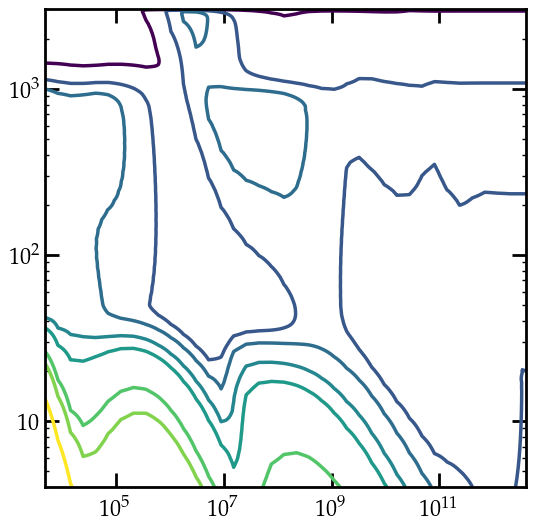

In [97]:
rs_vec = 3000*np.exp(-.001*np.arange(6620))
eng_arr = 5e3*10**(np.arange(40)*0.23252559)
eng_arr[-1]=10**12.60150599

plt.figure()

plt.loglog()

# plt.contour(eng_arr, rs_vec, np.transpose(np.log10(f_DH_list[:,:,0])), levels=np.log10([0.01, 0.1, 0.2, 0.5, 1, 5, 10, 50]))
# plt.contour(eng_arr, rs_vec, np.transpose(np.log10(f_phot_swave_Hion)), levels=np.log10(np.array([0.01, 0.1, 0.2, 0.5, 1, 5, 10, 50])))

plt.contour(
    eng_arr, rs_vec, np.transpose(np.log10(f_DH_list_new[:,0,:])), 
    levels=np.log10(np.array([0.01, 0.1, 0.2, 0.5, 1, 5, 10, 50])), 
#     colors='k', linestyles='dashed'
)



In [50]:
from tqdm import tqdm_notebook as tqdm

%autoreload
f_phot_swave_Hion = [
    [
        phys.f_std(eng, rs, inj_particle='phot', inj_type='swave', channel='H ion', struct=True)
        for rs in rs_vec
    ]
    for eng in tqdm(eng_arr)
]


 

In [60]:
import main

result = main.evolve(
            primary='phot_delta',
            DM_process='swave', mDM=10**12.01, sigmav = 3e-26,
            start_rs = 3000, end_rs=5.1,
            coarsen_factor=1, backreaction=False,
            struct_boost = phys.struct_boost_func('einasto_with_subs')
        )

../darkhistory/physics.py:471: RuntimeWarning: invalid value encountered in double_scalars
  / (1 + 0.6703 * (conv_fac*T_m)**0.5300)


In [65]:
result['f']['high']

{'H ion': array([0.00000000e+00, 1.60902022e-09, 3.14851903e-07, ...,
        2.09066636e-03, 2.09064949e-03, 2.09062485e-03]),
 'He ion': array([0., 0., 0., ..., 0., 0., 0.]),
 'exc': array([0.00000000e+00, 1.49102682e-09, 2.75404956e-07, ...,
        1.61460093e-03, 1.61461732e-03, 1.61462776e-03]),
 'heat': array([0.00000000e+00, 4.68300527e-07, 8.35316653e-05, ...,
        1.10100887e-05, 1.10104713e-05, 1.10108178e-05]),
 'cont': array([ 0.00000000e+00, -9.34893901e-09, -9.29201181e-07, ...,
        -1.44919409e-06, -1.44875576e-06, -1.44830969e-06])}

[4, 4000, 0.00031622776601683794, 0.2]

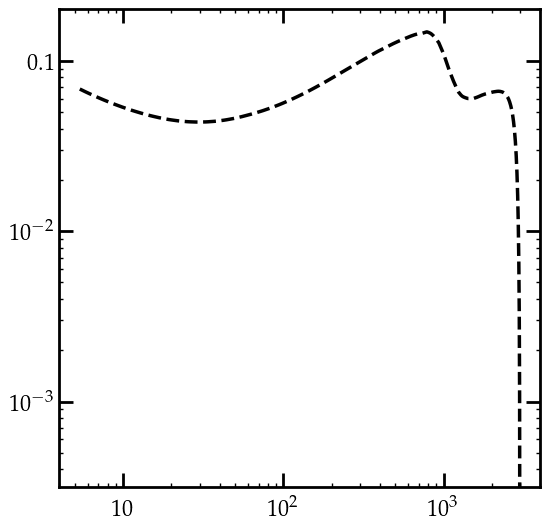

In [72]:
plt.figure()

plt.loglog()

plt.plot(result['rs'], result['f']['low']['H ion'] + 0*result['f']['high']['H ion'], 'k--')

plt.axis([4, 4000, 10**(-3.5), 0.2])

In [4]:
eng = np.array([1, 10, 100, 1000])
spec_arr = [Spectrum(eng, np.ones(4)*i, rs=100, spec_type='N') for i in np.arange(4)]
test_spectra = Spectra(spec_arr)
test_spectra.redshift(np.array([0.01, 0.1, 1, 10]))
print(test_spectra.grid_vals)

[[0. 0. 0. 0.]
 [1. 0. 0. 0.]
 [2. 2. 0. 0.]
 [3. 3. 3. 0.]]


In [5]:
a = Spectrum(eng, np.ones(4)*3, rs=100, spec_type='N') 
a.totN(bound_type='bin')

array([3., 3., 3., 3.])

In [6]:
0.5*13*10 + 14*100 + 15*1000

16465.0

In [7]:
9*0.5 + 10 + 11

25.5

In [8]:
12*1 + 13*10 + 14*100 + 15*1000

16542

In [9]:
1*10 + 2*100

210

In [10]:
%autoreload 2
phys.Tm_std(100)

array(0.01421714)

In [11]:
a = phys.struct_boost_func()

In [12]:
a(1)

17090553.829749867

In [16]:
%autoreload
phys.f_std(3e5, 300, inj_particle='phot', inj_type='decay', channel='heat')

0.026887206624840804

In [17]:
from config import load_data

In [19]:
a = load_data('dep_tf')

****** Loading transfer functions... ******
    for propagating photons...   Done!
    for low-energy photons...  Done!
    for low-energy electrons...  Done!
    for high-energy deposition...  Done!
    for total upscattered CMB energy rate...  Done!
****** Loading complete! ******


In [36]:
hep_tf = a['highengphot']
lep_tf  = a['lowengphot']
lee_tf  = a['lowengelec']

In [51]:
%%cython

def coarsen_matrices(hep, lep, lee, cf):
    prop_tf = np.zeros_like(hep)
    for i in np.arange(cf):
        prop_tf += np.linalg.matrix_power(hep, i)
    lep = np.matmul(prop_tf, lep)
    lee = np.matmul(prop_tf, lee)
    hep = np.linalg.matrix_power(hep, cf)




Error compiling Cython file:
------------------------------------------------------------
...

def coarsen_matrices(hep, lep, lee, cf):
    prop_tf = np.zeros_like(hep)
             ^
------------------------------------------------------------

/Users/hongwan/.ipython/cython/_cython_magic_b361c7d14b275e957a0cb6ae36816e8b.pyx:3:14: undeclared name not builtin: np


TypeError: object of type 'NoneType' has no len()

In [ ]:
from tqdm import tqdm_notebook as tqdm

cf = 12

for (hep_reg, lep_reg, lee_reg) in zip(hep_tf.grid_vals, lep_tf.grid_vals, lee_tf.grid_vals):
    for (hep_dim_1, lep_dim_1, lee_dim_1) in zip(tqdm(hep_reg), lep_reg, lee_reg):
        if hep_dim_1.ndim == 2:
            coarsen_matrices(hep_dim_1, lep_dim_1, lee_dim_1, cf)
        else:
            for (hep_dim_2, lep_dim_2, lee_dim_2) in zip(tqdm(hep_dim_1), lep_dim_1, lee_dim_1):
                if hep_dim_2.ndim == 2:
                    coarsen_matrices(hep_dim_2, lep_dim_2, lee_dim_2, cf)
                else:
                    for (hep_dim_3, lep_dim_3, lee_dim_3) in zip(hep_dim_2, lep_dim_2, lee_dim_2):
                        coarsen_matrices(hep_dim_3, lep_dim_3, lee_dim_3, cf)
        
            